#### Prerequisites
A trained model and tokenizer (already done).
A dataset of events (the original dataset used to train the model).
Python packages: numpy, pandas, scikit-learn, matplotlib/seaborn.
### 1. Extracting All Token Embeddings
The model’s input embedding matrix maps each token ID to a vector. We can simply query model.get_input_embeddings() to get them.

In [1]:
import torch
import pandas as pd
from transformers import GPT2LMHeadModel, PreTrainedTokenizerFast

# Paths
MODEL_DIR = "./gpt2-medium-finetuned-causal-vocab/checkpoint-180000" # "./gpt2-medium-finetuned-fixed-vocab/checkpoint-48000"
EMBEDDINGS_FILE = "token_embeddings.csv"   # if previously saved
PLAYER_METADATA_FILE = "player_metadata.csv"

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GPT2LMHeadModel.from_pretrained(MODEL_DIR)
model.to(device)
model.eval()

# Load the tokenizer
tokenizer = PreTrainedTokenizerFast(tokenizer_file=f"custom_whitespace_tokenizer.json")
for i in range(tokenizer.vocab_size):
    print(f"Token ID {i}: {tokenizer.convert_ids_to_tokens(i)}")
print(tokenizer.vocab_size)


# Option 1: If you already have tokenizer.json
# tokenizer = PreTrainedTokenizerFast(tokenizer_file="tokenizer.json")


# Option 2 (If you need to re-extract embeddings):
# embeddings = model.get_input_embeddings().weight.data.cpu().numpy()
# tokens = tokenizer.convert_ids_to_tokens(range(model.config.vocab_size))
# df_embeddings = pd.DataFrame(embeddings, columns=[f"dim_{i}" for i in range(embeddings.shape[1])])
# df_embeddings.insert(0, "token", tokens)

# Load player metadata
# df_player = pd.read_csv(PLAYER_METADATA_FILE)
# df_player.set_index("player_name", inplace=True, drop=True)

# Now you have:
# df_embeddings: token | dim_0 | dim_1 | ... 
# df_player: per-player metadata with index = player_name

# For merging, ensure token names match player names if you're merging
# If player names in df_player differ from tokens in df_embeddings, you might need to transform them.
# For example, if player tokens are "James_Harden" and df_player uses "James Harden" you might replace spaces:
# df_player.index = df_player.index.str.replace(" ", "_")

# Merge on token (assuming player tokens match df_player index):
# df_merged = df_embeddings.merge(df_player, left_on="token", right_index=True, how="inner")

# print(df_merged.head())


/home/mgrim/miniconda3/envs/nba-sim/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Token ID 0: [UNK]
Token ID 1: :
Token ID 2: 0
Token ID 3: <
Token ID 4: >
Token ID 5: EVENT_END
Token ID 6: OnBenchAway
Token ID 7: OnBenchHome
Token ID 8: OnCourtAway
Token ID 9: OnCourtHome
Token ID 10: .
Token ID 11: Home
Token ID 12: Away
Token ID 13: NoFoul
Token ID 14: Shot
Token ID 15: NoBlock
Token ID 16: NoAssist
Token ID 17: Q4
Token ID 18: Q2
Token ID 19: Rebound
Token ID 20: Q3
Token ID 21: Q1
Token ID 22: 2PT
Token ID 23: GameAdmin
Token ID 24: Missed
Token ID 25: Made
Token ID 26: 00
Token ID 27: 3PT
Token ID 28: 2
Token ID 29: 5
Token ID 30: DefensiveRebound
Token ID 31: 10
Token ID 32: 6
Token ID 33: 7
Token ID 34: 4
Token ID 35: 25
Token ID 36: 8
Token ID 37: 1
Token ID 38: 3
Token ID 39: MIA
Token ID 40: LAL
Token ID 41: 03
Token ID 42: 9
Token ID 43: BOS
Token ID 44: 26
Token ID 45: DEN
Token ID 46: 11
Token ID 47: GSW
Token ID 48: 01
Token ID 49: 04
Token ID 50: 02
Token ID 51: 06
Token ID 52: Free_Throw
Token ID 53: Substitution
Token ID 54: 05
Token ID 55: 07
Toke

In [2]:
import torch
import pandas as pd

# Assuming `model` and `tokenizer` are loaded
embeddings = model.get_input_embeddings().weight.data.cpu().numpy()
vocab_size, embedding_dim = embeddings.shape

# Convert vocab to a DataFrame: token|embedding_1|embedding_2|...|embedding_dim
tokens = tokenizer.convert_ids_to_tokens(range(vocab_size))
df_embeddings = pd.DataFrame(embeddings, columns=[f"dim_{i}" for i in range(embedding_dim)])
df_embeddings.insert(0, "token", tokens)

# Save to CSV or Parquet
df_embeddings.to_csv("token_embeddings.csv", index=False)

In [3]:
print(df_embeddings["token"])

0      [UNK]
1          :
2          0
3          <
4          >
       ...  
802      166
803      167
804        -
805      152
806      170
Name: token, Length: 807, dtype: object


### 2. Finding the Most Similar Tokens to a Given Player Name
You can compute similarities using cosine similarity. Given a player’s token, fetch its embedding, then compute cosine similarity with all tokens.

In [4]:
len(tokens)

807

In [24]:
import numpy as np

def find_top_k_similar_tokens(query_token, k=5):
    # Convert token to ID
    print(query_token)
    token_id = tokenizer.convert_tokens_to_ids(query_token)
    query_vec = embeddings[token_id]  # shape (embedding_dim,)

    # Compute cosine similarity with all tokens
    norm_emb = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    norm_query = query_vec / np.linalg.norm(query_vec)
    similarities = np.dot(norm_emb, norm_query)  # shape (vocab_size,)

    # Get top-k indices
    top_k_indices = np.argsort(similarities)[::-1][:k+1]  # first is the token itself
    # Exclude the query token if you don't want it in results
    top_k_indices = [idx for idx in top_k_indices if idx != token_id][:k]

    return [(tokens[i], similarities[i]) for i in top_k_indices]

# Example usage:
similar = find_top_k_similar_tokens("Al_Horford", k=5)
print(similar)

Al_Horford
[('Damion_Lee', np.float32(0.58690226)), ('Nicolas_Batum', np.float32(0.571655)), ('Josh_Okogie', np.float32(0.5611865)), ('Franz_Wagner', np.float32(0.55195415)), ('Anthony_Davis', np.float32(0.5416399))]


### 3. Parsing Original Dataset to Create Player Metadata
You have an original play-by-play dataset. Assume it has columns for events: shots, rebounds, assists, etc. The goal is to compute aggregated metadata (3 pointers made, assists, rebounds, etc.) per player.

Approach:

* Parse the dataset line by line, extracting relevant events.
* Accumulate statistics per player (e.g., player name is a token, or a column in the dataset).
* Create a DataFrame indexed by player_name with columns for various stats.

In [6]:
df_player = pd.read_csv("player_metadata.csv").rename({"Unnamed: 0": "token"}, axis=1)


print(df_player.head())

print(df_embeddings.head())

            token  3pm  2pm  Assists  Rebounds  Blocks  Games
0  Gary_Payton_II   24   77       39       113      11     34
1    Malcolm_Hill    2    2        0         3       0      2
2       Ish_Smith   10   53      101        55       7     41
3   Jacob_Gilyard    2    1        7         4       0      1
4    Daniel_Theis    9   21        9        22       6      7
   token     dim_0     dim_1     dim_2     dim_3     dim_4     dim_5  \
0  [UNK]  0.012993 -0.015423  0.019942 -0.010069  0.085823  0.129308   
1      :  0.015566  0.103145  0.012470 -0.056370 -0.013264  0.064829   
2      0  0.044092  0.076047  0.026603  0.017583  0.150083  0.100846   
3      < -0.011143  0.131896  0.016118 -0.199703  0.122310 -0.079672   
4      > -0.095045 -0.113386  0.016689 -0.013339 -0.064590 -0.027674   

      dim_6     dim_7     dim_8  ...  dim_1014  dim_1015  dim_1016  dim_1017  \
0  0.069768  0.046733 -0.088927  ... -0.040559 -0.062660 -0.104292 -0.114330   
1 -0.042576  0.033310  0.038631  ..

### 4. Plot the Embeddings Colored by Metadata
Now that you have embeddings (df_embeddings) and metadata (df_player), merge them on player_name.

Caveat:

Ensure token names in df_embeddings['token'] match player names in df_player.index. If tokens differ (like underscores for spaces), preprocess the player column in df_player or the token column in df_embeddings.

/home/mgrim/miniconda3/envs/nba-sim/lib/python3.11/site-packages/matplotlib/text.py:762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(x))
/home/mgrim/miniconda3/envs/nba-sim/lib/python3.11/site-packages/matplotlib/text.py:763: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(y))
/home/mgrim/miniconda3/envs/nba-sim/lib/python3.11/site-packages/matplotlib/text.py:905: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/home/mgrim/miniconda3/envs/nba-sim/lib/python3.11/site-packages/matplotlib/text.py:906: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeErro

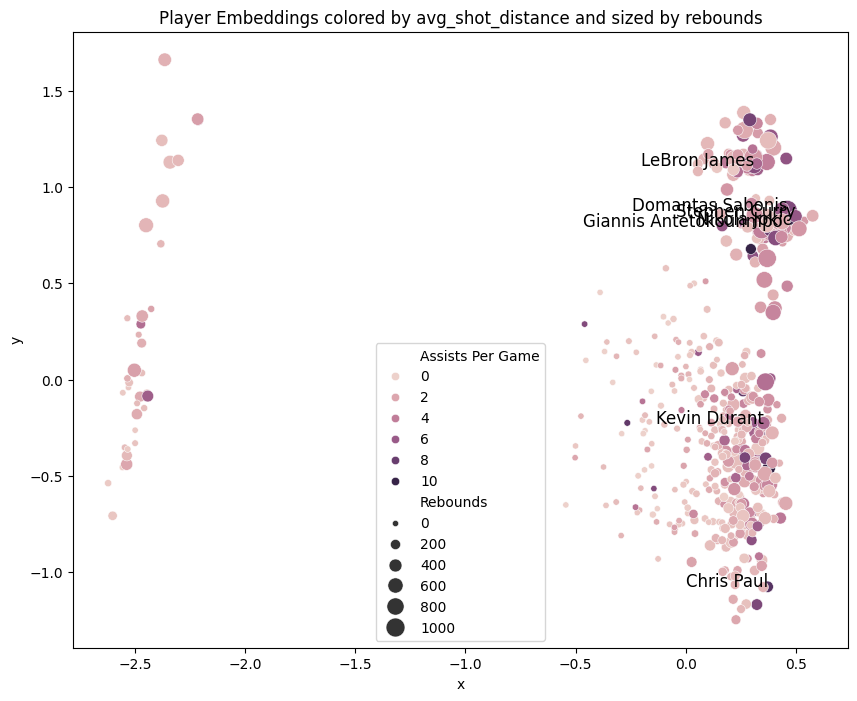

In [11]:
# Let's assume player tokens match df_player index (like 'James_Harden')
df_merged = df_embeddings.merge(df_player, on='token', how='right').dropna()

df_merged["3pm Per Game"] = df_merged["3pm"] / df_merged["Games"]
df_merged["2pm Per Game"] = df_merged["2pm"] / df_merged["Games"]
df_merged["Assists Per Game"] = df_merged["Assists"] / df_merged["Games"]
df_merged["Rebounds Per Game"] = df_merged["Rebounds"] / df_merged["Games"]


# Now df_merged has embedding columns (dim_0...dim_n) and metadata columns.
# Reduce to 2D with PCA or t-SNE
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
coords = pca.fit_transform(df_merged[[c for c in df_merged.columns if c.startswith('dim_')]])

df_merged['x'] = coords[:,0]
df_merged['y'] = coords[:,1]

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,8))
sns.scatterplot(data=df_merged, x='x', y='y', hue="Assists Per Game", size="Rebounds", sizes=(20, 200))

# Annotate Steph Curry
steph = df_merged.loc[df_merged['token'] == 'Stephen_Curry']
plt.text(steph['x'], steph['y'], 'Stephen Curry', fontsize=12, ha='right')

# Annotate LeBron James
lebron = df_merged.loc[df_merged['token'] == 'LeBron_James']
plt.text(lebron['x'], lebron['y'], 'LeBron James', fontsize=12, ha='right')

# Annotate Nikola Jokic
jokic = df_merged.loc[df_merged['token'] == 'Nikola_Jokic']
plt.text(jokic['x'], jokic['y'], 'Nikola Jokic', fontsize=12, ha='right')

# Annotate Kevin Durant
kd = df_merged.loc[df_merged['token'] == 'Kevin_Durant']
plt.text(kd['x'], kd['y'], 'Kevin Durant', fontsize=12, ha='right')

# Annotate Giannis Antetokounmpo
giannis = df_merged.loc[df_merged['token'] == 'Giannis_Antetokounmpo']
plt.text(giannis['x'], giannis['y'], 'Giannis Antetokounmpo', fontsize=12, ha='right')

# Annotate Chris Paul
cp3 = df_merged.loc[df_merged['token'] == 'Chris_Paul']
plt.text(cp3['x'], cp3['y'], 'Chris Paul', fontsize=12, ha='right')

# Annotate Damontas Sabonis
sabonis = df_merged.loc[df_merged['token'] == 'Domantas_Sabonis']
plt.text(sabonis['x'], sabonis['y'], 'Domantas Sabonis', fontsize=12, ha='right')

plt.title("Player Embeddings colored by avg_shot_distance and sized by rebounds")
plt.show()


/home/mgrim/miniconda3/envs/nba-sim/lib/python3.11/site-packages/matplotlib/text.py:762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(x))
/home/mgrim/miniconda3/envs/nba-sim/lib/python3.11/site-packages/matplotlib/text.py:763: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(y))
/home/mgrim/miniconda3/envs/nba-sim/lib/python3.11/site-packages/matplotlib/text.py:905: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/home/mgrim/miniconda3/envs/nba-sim/lib/python3.11/site-packages/matplotlib/text.py:906: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeErro

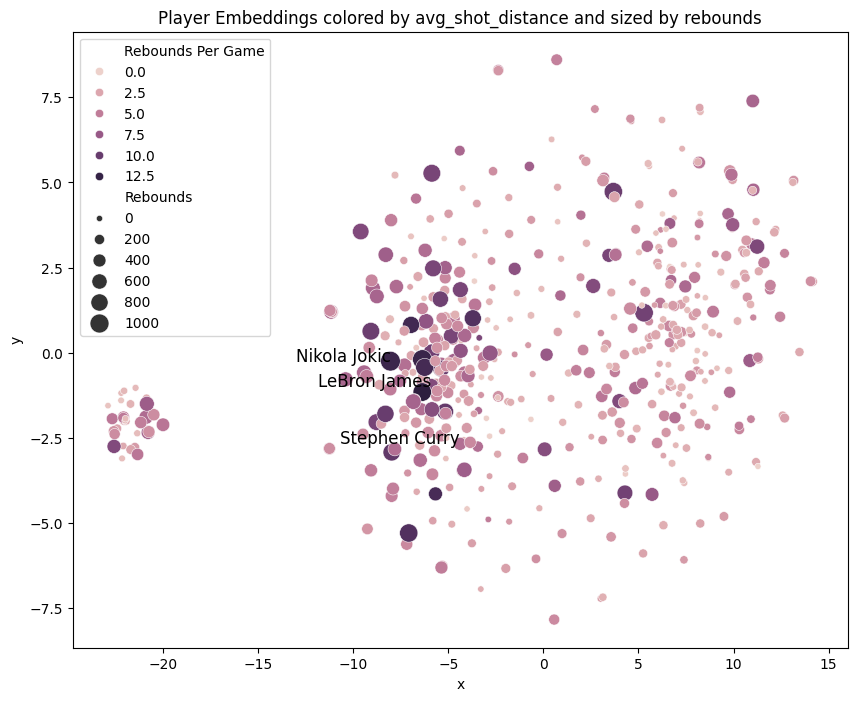

In [8]:
# Now do t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
coords = tsne.fit_transform(df_merged[[c for c in df_merged.columns if c.startswith('dim_')]])

df_merged['x'] = coords[:,0]
df_merged['y'] = coords[:,1]

plt.figure(figsize=(10,8))
sns.scatterplot(data=df_merged, x='x', y='y', hue="Rebounds Per Game", size="Rebounds", sizes=(20, 200))

# Annotate Steph Curry
steph = df_merged.loc[df_merged['token'] == 'Stephen_Curry']
plt.text(steph['x'], steph['y'], 'Stephen Curry', fontsize=12, ha='right')

# Annotate LeBron James
lebron = df_merged.loc[df_merged['token'] == 'LeBron_James']
plt.text(lebron['x'], lebron['y'], 'LeBron James', fontsize=12, ha='right')

# Annotate Nikola Jokic
jokic = df_merged.loc[df_merged['token'] == 'Nikola_Jokic']
plt.text(jokic['x'], jokic['y'], 'Nikola Jokic', fontsize=12, ha='right')

plt.title("Player Embeddings colored by avg_shot_distance and sized by rebounds")
plt.show()

In [9]:
# Train a simple NN model to predict 3pm Per Game from embeddings
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

df_merged = df_merged.dropna()

X = df_merged[[c for c in df_merged.columns if c.startswith('dim_')]]
y = df_merged['3pm Per Game']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

test_model = MLPRegressor(hidden_layer_sizes=(16, 24), max_iter=75, random_state=42)
test_model.fit(X_train, y_train)

print(test_model.score(X_train, y_train))
print(test_model.score(X_test, y_test))

0.5128663243781031
0.2757388596820336


/home/mgrim/miniconda3/envs/nba-sim/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (75) reached and the optimization hasn't converged yet.
  warnings.warn(


In [10]:
# Perform rollout on the model
starting_text = "Q1 0:11:38 0 0 None PHI OnCourtAway James_Harden Joel_Embiid PJ_Tucker Tobias_Harris Tyrese_Maxey OnBenchAway Danuel_House_Jr DeAnthony_Melton Georges_Niang Matisse_Thybulle Montrezl_Harrell BOS OnCourtHome Al_Horford Derrick_White Jaylen_Brown Jayson_Tatum Marcus_Smart OnBenchHome Blake_Griffin Grant_Williams Malcolm_Brogdon Noah_Vonleh Sam_Hauser"

# Tokenize the text
input_ids = tokenizer.encode(starting_text, return_tensors="pt").to(device)

# Generate text
output = model.generate(input_ids, max_length=100, num_return_sequences=1, do_sample=True, temperature=0.9)

# Decode and print
decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)

print(starting_text)
print(decoded_output)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Q1 0:11:38 0 0 None PHI OnCourtAway James_Harden Joel_Embiid PJ_Tucker Tobias_Harris Tyrese_Maxey OnBenchAway Danuel_House_Jr DeAnthony_Melton Georges_Niang Matisse_Thybulle Montrezl_Harrell BOS OnCourtHome Al_Horford Derrick_White Jaylen_Brown Jayson_Tatum Marcus_Smart OnBenchHome Blake_Griffin Grant_Williams Malcolm_Brogdon Noah_Vonleh Sam_Hauser
Q1 0 : 11 : 38 0 0 None PHI OnCourtAway James_Harden Joel_Embiid PJ_Tucker Tobias_Harris Tyrese_Maxey OnBenchAway Danuel_House_Jr DeAnthony_Melton Georges_Niang Matisse_Thybulle Montrezl_Harrell BOS OnCourtHome Al_Horford Derrick_White Jaylen_Brown Jayson_Tatum Marcus_Smart OnBenchHome Blake_Griffin Grant_Williams Malcolm_Brogdon Noah_Vonleh Sam_Hauser Q1 0 : 06 : 50 11 14 Home MIL OnCourtAway Bobby_Portis Brook_Lopez Giannis_Antetokounmpo Grayson_Allen Jae_Crowder Jevon_Carter Jrue_Holiday Khris_Middleton Pat_Connaughton SAC OnCourtHome Chimezie_Metu Davion_Mitchell Domantas_Sabonis Harrison_Barnes Keegan_Murray Kessler_Edwards Kevin_Huerte